In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:

# -*- coding: utf-8 -*-
import os
import argparse
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms


from metadatas import *
from augmentations import *

from models.classification_heads import ClassificationHead, R2D2Head
from models.classification_heads import ClassificationHead_Mixup, R2D2Head_Mixup
from models.R2D2_embedding import R2D2Embedding
from models.R2D2_embedding_mixup import R2D2Embedding_mixup
from models.protonet_embedding import ProtoNetEmbedding
from models.ResNet12_embedding import resnet12 
from models.ResNet12_embedding_mixup import resnet12_mixup 
from InstaAug_module import learnable_invariance

from utils import set_gpu, Timer, count_accuracy, count_accuracy_mixup, check_dir, log
import matplotlib.pyplot as plt

import pdb
import time
import wandb
import yaml


#np.seterr(all='raise')

def mixup_data(x, y, lam, use_cuda=False):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).to(DEVICE)
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    loss = 0.
    for i in range(len(pred)):
        loss += lam[i] * criterion(pred[i], y_a[i]) + (1 - lam[i]) * criterion(pred[i], y_b[i])

    return loss/len(pred)


def one_hot(indices, depth):
    """
    Returns a one-hot tensor.
    This is a PyTorch equivalent of Tensorflow's tf.one_hot.
        
    Parameters:
      indices:  a (n_batch, m) Tensor or (m) Tensor.
      depth: a scalar. Represents the depth of the one hot dimension.
    Returns: a (n_batch, m, depth) Tensor or (m, depth) Tensor.
    """

    encoded_indicies = torch.zeros(indices.size() + torch.Size([depth])).to(DEVICE)
    index = indices.view(indices.size()+torch.Size([1]))
    encoded_indicies = encoded_indicies.scatter_(1,index,1)
    
    return encoded_indicies

def get_model(options):
    # Choose the embedding network
    if options.network == 'ProtoNet':
        network = ProtoNetEmbedding().to(DEVICE)
    elif options.network == 'R2D2':
        network = R2D2Embedding().to(DEVICE)
    elif options.network == 'R2D2_mixup':
        network = R2D2Embedding_mixup().to(DEVICE)
    elif options.network == 'ResNet_mixup':
        network = resnet12_mixup(avg_pool=False, drop_rate=0.1, dropblock_size=2).to(DEVICE)
    elif options.network == 'ResNet':
        if options.dataset == 'miniImageNet' or options.dataset == 'tieredImageNet':
            network = resnet12(avg_pool=False, drop_rate=0.1, dropblock_size=4).to(DEVICE)
            network = torch.nn.DataParallel(network)
        else:
            network = resnet12(avg_pool=False, drop_rate=0.1, dropblock_size=2).to(DEVICE)
            network = torch.nn.DataParallel(network)
    else:
        print ("Cannot recognize the network type")
        assert(False)
        
    # Choose the classification head
    if options.head == 'ProtoNet':
        cls_head = ClassificationHead(base_learner='ProtoNet').to(DEVICE)
    elif options.head == 'Ridge':
        cls_head = ClassificationHead(base_learner='Ridge').to(DEVICE)
    elif options.head == 'R2D2':
        cls_head = R2D2Head().to(DEVICE) 
    elif options.head == 'SVM':
        cls_head = ClassificationHead(base_learner='SVM-CS').to(DEVICE)
    else:
        print ("Cannot recognize the dataset type")
        assert(False)
        
    if options.support_aug and 'mix' in options.support_aug:
        if options.head == 'R2D2':
            cls_head_mixup = R2D2Head_Mixup().to(DEVICE)
        elif options.head == 'SVM':
            cls_head_mixup = ClassificationHead_Mixup(base_learner='SVM-CS').to(DEVICE)
        else:
            print("Cannot recognize the dataset type")

        return (network, cls_head, cls_head_mixup)
        
    else:
        return (network, cls_head)


def get_datasets(name, phase, args):
    random_cropping = False if args.no_random_cropping else True
    color_jitter = False if args.no_color_jitter else True
    
    if name == 'miniImageNet':
        dataset = MiniImageNet(phase=phase, augment=args.feat_aug, rot90_p=args.t_p, random_cropping=random_cropping, color_jitter=color_jitter)  
    elif name == 'CIFAR_FS':
        dataset = CIFAR_FS(phase=phase, augment=args.feat_aug, rot90_p=args.t_p, random_cropping=random_cropping, color_jitter=color_jitter)
    # elif name == 'FC100':
    #     dataset = FC100(phase=phase, augment=args.feat_aug, rot90_p=args.t_p)
    else:
        print ("Cannot recognize the dataset type")
        assert(False)
    print(dataset)

    if phase == 'train':
        for ta in args.task_aug:
            if ta == 'Rot90':
                dataset = Rot90(dataset, p=args.t_p, batch_size_down=8e4)
                dataset.batch_num.value += args.num_epoch * 0.
            elif ta == 'Mix':
                dataset = TaskAug(dataset, "Mix", p=args.t_p, batch_size_down=8e4)
            elif ta == 'CutMix':
                dataset = TaskAug(dataset, "CutMix", p=args.t_p, batch_size_down=8e4)
            elif ta == 'FMix':
                dataset = TaskAug(dataset, "FMix", p=args.t_p, batch_size_down=8e4)
            elif ta == 'Combine':
                dataset = TaskAug(dataset, "Combine", p=args.t_p, batch_size_down=8e4)
            elif ta == 'DropChannel':
                dataset = DropChannels(dataset, p=args.t_p) 
            elif ta == 'RE':
                dataset = RE(dataset, p=args.t_p) 
            elif ta == 'Solarize':
                dataset = Solarize(dataset, p=args.t_p) 
            else:
                print ("Cannot recognize the task augmentation type")
                continue
            print(dataset)

    return dataset

def apply_instance_aug(instance_aug_module, x, dataset_source="CIFAR_FS"):
    '''
    Params:
        instance_aug_module: torch.Module
        x: input data
        dataset source: str (either TinyImageNet or CIFAR_FS)

    Returns:
        instance augmentation applied on x
    '''
    return instance_aug_module(x)

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--num-epoch', type=int, default=40,
                        help='number of training epochs')
parser.add_argument('--save-epoch', type=int, default=10,
                        help='frequency of model saving')
parser.add_argument('--train-shot', type=int, default=5,
                        help='number of support examples per training class')
parser.add_argument('--val-shot', type=int, default=5,
                        help='number of support examples per validation class')
parser.add_argument('--train-query', type=int, default=6,
                        help='number of query examples per training class')
parser.add_argument('--val-episode', type=int, default=2000,
                        help='number of episodes per validation')
parser.add_argument('--val-query', type=int, default=15,
                        help='number of query examples per validation class')
parser.add_argument('--train-way', type=int, default=5,
                        help='number of classes in one training episode')
parser.add_argument('--sample-way', type=int, default=5,
                        help='number of classes sampled in one training episode (i.e. sample 10 classes for task mixup)')
parser.add_argument('--test-way', type=int, default=5,
                        help='number of classes in one test (or validation) episode')
parser.add_argument('--save-path', default='./experiments/exp_1')
parser.add_argument('--gpu', default='0, 1, 2, 3')
parser.add_argument('--network', type=str, default='ProtoNet',
                        help='choose which embedding network to use. ProtoNet, R2D2, ResNet')
parser.add_argument('--head', type=str, default='ProtoNet',
                        help='choose which classification head to use. ProtoNet, Ridge, R2D2, SVM')
parser.add_argument('--dataset', type=str, default='miniImageNet',
                        help='choose which classification head to use. miniImageNet, tieredImageNet, CIFAR_FS, FC100')
parser.add_argument('--episodes-per-batch', type=int, default=8,
                        help='number of episodes per batch')
parser.add_argument('--num-per-batch', type=int, default=1000,
                        help='number of epoch size per train epoch')
parser.add_argument('--eps', type=float, default=0.0,
                        help='epsilon of label smoothing')

parser.add_argument('--load', default=None,
                        help='path of the checkpoint file')
## Data Augmentation
parser.add_argument('--feat_aug', '-faug', default='norm', type=str,
                    help='If use feature level augmentation.')
parser.add_argument('--task_aug', '-taug', default=[], nargs='+', type=str,
                    help='If use task level data augmentation.')
parser.add_argument('--support_aug', '-saug', default=None, type=str,
                    help='If use support level data augmentation.')
parser.add_argument('--shot_aug', '-shotaug', default=[], nargs='+', type=str,
                    help='If use shot level data augmentation.')
parser.add_argument('--query_aug', '-qaug', default=[], nargs='+', type=str,
                    help='If use query level data augmentation.')
parser.add_argument('--t_p', '-tp', default=1, type=float,
                    help='The possibility of sampling categories or images with rot90.')
parser.add_argument('--s_p', '-sp', default=1, type=float,
                    help='The possibility of using support level data augmentation')
parser.add_argument('--s_du', '-sdu', default=1, type=int,
                    help='number of support examples augmented by shot')
parser.add_argument('--q_p', '-qp', default=[], nargs='+', type=float,
                    help='The possibility of using query level data augmentation')
parser.add_argument('--rot_degree', default=30, type=int,
                    help='Degree for random rotation when using rotation in support or query level augmentation.')
# New Parser args for instaaug
parser.add_argument('--Li_config_path', default=None, type=str,
                    help="Config path for the learnable invariance, assuming it is included in one of the augmentations")
parser.add_argument('--no_random_cropping', action="store_true",
                    help="whether to use random cropping as a default transform")
parser.add_argument('--no_color_jitter', action="store_true",
                    help="whether to use color_jitter as a default transform")
parser.add_argument('--wandb', default=False, type=bool,
                    help="whether to use wandb")
parser.add_argument('--min_entropy', default=-1, type=float,
                    help='Minimum entropy to use in case of instance based augmentation')
parser.add_argument('--max_entropy', default=-1, type=float,
                    help='Maximum entropy to use in case of instance based augmentation')

opt = parser.parse_args('--gpu 0 --train-shot 1 --val-shot 1 \
   --head ProtoNet --network ResNet --dataset CIFAR_FS --query_aug random_erase --q_p 1. \
   --no_color_jitter --no_random_cropping'.split())



In [3]:
if opt.wandb:
    wandb.init(project="330proj", entity="erictang000")

trainset = get_datasets(opt.dataset, 'train', opt)
valset = get_datasets(opt.dataset, 'val', opt)

epoch_s = opt.episodes_per_batch * opt.num_per_batch

dloader_train = FewShotDataloader(trainset, kway=opt.sample_way, kshot=opt.train_shot, kquery=opt.train_query,
                                batch_size=opt.episodes_per_batch, num_workers=0, epoch_size=epoch_s, shuffle=True)
dloader_val = FewShotDataloader(valset, kway=opt.test_way, kshot=opt.val_shot, kquery=opt.val_query,
                                batch_size=1, num_workers=1, epoch_size=opt.val_episode, shuffle=False, fixed=False)

Loading CIFAR-FS dataset - phase train
CIFAR_FS(phase=train, augment=norm)
Loading CIFAR-FS dataset - phase val
CIFAR_FS(phase=val, augment=null)


In [8]:
set_gpu(opt.gpu)
check_dir('./experiments/')
check_dir(opt.save_path)

log_file_path = os.path.join(opt.save_path, "train_log.txt")
log(log_file_path, str(vars(opt)))

# Check whether or not to initialize instance augmentation module:
Li_configs={'li_flag': False}
if (opt.support_aug and "instance" in opt.support_aug) or (opt.query_aug and "instance" in opt.query_aug) or (opt.shot_aug and "instance" in opt.shot_aug):
    # initialize instance augmentation module

    if opt.Li_config_path:
        Li_configs=yaml.safe_load(open(opt.Li_config_path,'r'))
    else:
        print("instance module specified, but config not provided")
        exit(0)
    if opt.min_entropy != -1:
        Li_configs["entropy_min_thresholds"] = [opt.min_entropy]
    if opt.max_entropy != -1:
        Li_configs["entropy_max_thresholds"] = [opt.max_entropy]
    instance_aug_module = learnable_invariance(Li_configs).to(DEVICE)
    optimizer_Li=torch.optim.SGD(instance_aug_module.parameters(), lr=Li_configs['lr'])
    start_entropy = None

if (opt.support_aug and "random_crop" in opt.support_aug) or (opt.query_aug and "random_crop" in opt.query_aug) or (opt.shot_aug and "random_crop" in opt.shot_aug):
    random_crop = transforms.Compose([
        transforms.RandomResizedCrop(32, scale=[0.2, 1]),
    ])
if (opt.support_aug and "random_erase" in opt.support_aug) or (opt.query_aug and "random_erase" in opt.query_aug) or (opt.shot_aug and "random_erase" in opt.shot_aug):
    random_erase = transforms.Compose([
        transforms.RandomErasing(value="random"),
    ])

    
# Choosing whether to use mix classifier for base-learner
if opt.support_aug and "mix" in opt.support_aug:
    (embedding_net, cls_head, cls_head_mixup) = get_model(opt)
    embedding_net.to(DEVICE)
    cls_head.to(DEVICE)
    cls_head_mixup.to(DEVICE)

    optimizer = torch.optim.SGD([{'params': embedding_net.parameters()}, 
                                    {'params': cls_head_mixup.parameters()}], lr=0.1, momentum=0.9, \
                                        weight_decay=5e-4, nesterov=True)
else:
    (embedding_net, cls_head) = get_model(opt)
    embedding_net = embedding_net.to(DEVICE)
    cls_head = cls_head.to(DEVICE)

    optimizer = torch.optim.SGD([{'params': embedding_net.parameters()}, 
                                    {'params': cls_head.parameters()}], lr=0.1, momentum=0.9, \
                                        weight_decay=5e-4, nesterov=True)

lambda_epoch = lambda e: 1.0 if e < 20 else (0.06 if e < 40 else 0.012 if e < 50 else (0.0024 if e < 60 else (0.001)))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch, last_epoch=-1)

max_val_acc = 0.0

timer = Timer()
x_entropy = torch.nn.CrossEntropyLoss()
x_entropy_Li = torch.nn.CrossEntropyLoss(reduction='none')

using gpu: 0
{'num_epoch': 40, 'save_epoch': 10, 'train_shot': 1, 'val_shot': 1, 'train_query': 6, 'val_episode': 2000, 'val_query': 15, 'train_way': 5, 'sample_way': 5, 'test_way': 5, 'save_path': './experiments/exp_1', 'gpu': '0', 'network': 'ResNet', 'head': 'ProtoNet', 'dataset': 'CIFAR_FS', 'episodes_per_batch': 8, 'num_per_batch': 1000, 'eps': 0.0, 'load': None, 'feat_aug': 'norm', 'task_aug': [], 'support_aug': None, 'shot_aug': [], 'query_aug': ['random_erase'], 't_p': 1, 's_p': 1, 's_du': 1, 'q_p': [1.0], 'rot_degree': 30, 'Li_config_path': None, 'no_random_cropping': True, 'no_color_jitter': True, 'wandb': False, 'min_entropy': -1, 'max_entropy': -1}


Train Epoch: 1	Learning Rate: 0.1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Train Epoch: 1	Batch: [100/1000]	Loss: 1.3287	Accuracy: 40.18 % (45.42 %)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Train Epoch: 1	Batch: [200/1000]	Loss: 1.1946	Accuracy: 43.23 % (56.67 %)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

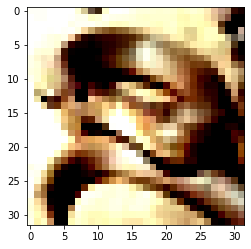

: 

In [9]:
for epoch in range(1, opt.num_epoch + 1):
    # Train on the training split
    
    # Fetch the current epoch's learning rate
    epoch_learning_rate = 0.1
    for param_group in optimizer.param_groups:
        epoch_learning_rate = param_group['lr']
        
    log(log_file_path, 'Train Epoch: {}\tLearning Rate: {:.4f}'.format(
                        epoch, epoch_learning_rate))
    
    _, _ = [x.train() for x in (embedding_net, cls_head)]
    
    train_accuracies = []
    train_s_accuracies = []
    train_losses = []
    train_LI_losses = []

    for i, batch in enumerate(dloader_train(epoch), 1):
        if "random_crop" in opt.shot_aug:
            data_support, labels_support, dc_s, data_query, labels_query, dc_q = [x.to(DEVICE) for x in batch]
        elif (opt.support_aug and "instance" in opt.support_aug) or (opt.query_aug and "instance" in opt.query_aug) or (opt.shot_aug and "instance" in opt.shot_aug):
            data_support, labels_support, dc_s, data_query, labels_query, dc_q = [x.to(DEVICE) for x in batch]
        else:
            data_support, labels_support, dc_s, data_query, labels_query, dc_q = [x for x in batch]

        train_n_support = opt.train_way * opt.train_shot 
        train_n_query = opt.train_way * opt.train_query 
        rs, rq = 0., 0.

        ## data augmentation for shots (increasing num of shots for support)
        for shot_method in opt.shot_aug:
            if shot_method == "instance":
                data_support, labels_support, train_n_support, _, _ = shot_aug(data_support, labels_support, train_n_support, shot_method, opt, instance_aug_module)
            elif shot_method == "random_crop":
                data_support, labels_support, train_n_support = shot_aug(data_support, labels_support, train_n_support, shot_method, opt, random_crop=random_crop)
            elif shot_method == "random_erase":
                data_support, labels_support, train_n_support = shot_aug(data_support, labels_support, train_n_support, shot_method, opt, random_erase=random_erase)
            else:
                data_support, labels_support, train_n_support = shot_aug(data_support, labels_support, train_n_support, shot_method, opt)
        ## data augmentation for support data
        if opt.support_aug and "instance" in opt.support_aug:
            e, b = data_support.shape[0], data_support.shape[1]
            data_support = data_support.view((-1, data_support.shape[2], data_support.shape[3], data_support.shape[4]))
            data_support, _, _, _ = apply_instance_aug(instance_aug_module, data_support)
            data_support = data_support.view((e, b, data_support.shape[1], data_support.shape[2], data_support.shape[3]))
        elif opt.support_aug and "random_crop" in opt.support_aug:
            e, b = data_support.shape[0], data_support.shape[1]
            data_support = data_support.view((-1, data_support.shape[2], data_support.shape[3], data_support.shape[4]))
            data_support = random_crop(data_support)
            data_support = data_support.view((e, b, data_support.shape[1], data_support.shape[2], data_support.shape[3]))
        elif opt.support_aug and "random_erase" in opt.support_aug:
            e, b = data_support.shape[0], data_support.shape[1]
            data_support = data_support.view((-1, data_support.shape[2], data_support.shape[3], data_support.shape[4]))
            data_support = random_erase(data_support)
            data_support = data_support.view((e, b, data_support.shape[1], data_support.shape[2], data_support.shape[3]))
        elif opt.support_aug and "mix" in opt.support_aug:
            data_support, label_support_a, label_support_b, lss, rs = data_aug_mix(data_support, labels_support, opt.s_p, opt.support_aug, opt)
            label_support_a, label_support_b = label_support_a.to(DEVICE), label_support_b.to(DEVICE)
        elif opt.support_aug:
            data_support, labels_support = data_aug(data_support, labels_support, opt.s_p, opt.support_aug, opt)

        ## data augmentation for query data
        for mi, query_method in enumerate(opt.query_aug):
            ## instance augmentation
            if "instance" in query_method:
                e, b = data_query.shape[0], data_query.shape[1]
                data_query = data_query.view((-1, data_query.shape[2], data_query.shape[3], data_query.shape[4]))
                # if i % 20 == 0:
                #     plt.imshow(np.transpose(data_query[0].detach().cpu().numpy(), (1, 2, 0)))
                #     plt.imsave("before.png", np.transpose(data_query[0].detach().cpu().numpy(), (1, 2, 0)).clip(0,1))
                data_query, logprobs, entropy_every, _, num_erased = apply_instance_aug(instance_aug_module, data_query)
                # if i % 20 == 0:
                #     print(num_erased)
                #     plt.imshow(np.transpose(data_query[0].detach().cpu().numpy(), (1, 2, 0)))
                #     plt.imsave("after.png", np.transpose(data_query[0].detach().cpu().numpy(), (1, 2, 0)).clip(0,1))
                data_query = data_query.view((e, b, data_query.shape[1], data_query.shape[2], data_query.shape[3]))
            elif "random_crop" in query_method:
                e, b = data_query.shape[0], data_query.shape[1]
                data_query = data_query.view((-1, data_query.shape[2], data_query.shape[3], data_query.shape[4]))
                data_query = random_crop(data_query)
                data_query = data_query.view((e, b, data_query.shape[1], data_query.shape[2], data_query.shape[3]))
            elif "random_erase" in query_method:
                e, b = data_query.shape[0], data_query.shape[1]
                data_query = data_query.view((-1, data_query.shape[2], data_query.shape[3], data_query.shape[4]))
                data_query = random_erase(data_query)
                data_query = data_query.view((e, b, data_query.shape[1], data_query.shape[2], data_query.shape[3]))
            elif "mix" in query_method:
                data_query, label_query_a, label_query_b, lqs, rq = data_aug_mix(data_query, labels_query, opt.q_p[mi], query_method, opt)
                mixp = opt.q_p[mi]
                label_query_a, label_query_b = label_query_a.to(DEVICE), label_query_b.to(DEVICE)
            else:
                data_query, labels_query = data_aug(data_query, labels_query, opt.q_p[mi], query_method, opt)

        ## related with the augmentation combine, where the sample ways are larger than train ways
        if data_support.shape[1] != train_n_support:
            data_support = data_support[labels_support < opt.train_way]
            labels_support = labels_support[labels_support < opt.train_way]
        if data_query.shape[1] != train_n_query:
            data_query = data_query[labels_query < opt.train_way]
            labels_query = labels_query[labels_query < opt.train_way]
            
        data_support, labels_support, data_query, labels_query = data_support.to(DEVICE), labels_support.to(DEVICE), data_query.to(DEVICE), labels_query.to(DEVICE)
        dc_s, dc_q = dc_s.to(DEVICE), dc_q.to(DEVICE)

        ## get embedding
        prob = random.random()
        if opt.support_aug and opt.support_aug == 'feature_mixup' and prob < opt.s_p:
            emb_support, label_support_a, label_support_b, lss = embedding_net(data_support.reshape([-1] + list(data_support.shape[-3:])), target=labels_support, mixup_hidden=True, opt=opt)
        else:
            emb_support = embedding_net(data_support.reshape([-1] + list(data_support.shape[-3:])))
        emb_support = emb_support.reshape(opt.episodes_per_batch, train_n_support, -1)
        
        if opt.query_aug and opt.query_aug == 'feature_mixup' and prob < opt.q_p :
            emb_query, label_query_a, label_query_b, lqs = embedding_net(data_query.reshape([-1] + list(data_query.shape[-3:])), target=labels_query, mixup_hidden=True, opt=opt)
        else:
            emb_query = embedding_net(data_query.reshape([-1] + list(data_query.shape[-3:])))
        emb_query = emb_query.reshape(opt.episodes_per_batch, train_n_query, -1)
        
        ## get logits for query embedding
        if opt.support_aug and "mix" in opt.support_aug and rs < opt.s_p:
            logit_query = cls_head_mixup(emb_query, emb_support, label_support_a, label_support_b, lss, opt.train_way, opt.train_shot)
        else:
            logit_query = cls_head(emb_query, emb_support, labels_support, opt.train_way, opt.train_shot * opt.s_du)
            labels_support = labels_support.view(-1)

        ## get loss for the outer loop
        is_query_mix = any('mix' in m for m in opt.query_aug)
        if is_query_mix and rq < mixp:
            loss = mixup_criterion(x_entropy, logit_query, label_query_a, label_query_b, lqs)
            acc = count_accuracy_mixup(logit_query, label_query_a, label_query_b, lqs)
        else:
            logit_query = logit_query.view(-1, opt.train_way)
            labels_query = labels_query.view(-1)
            loss = x_entropy(logit_query, labels_query)
            acc = count_accuracy(logit_query, labels_query)


        ## get accuracies
        train_accuracies.append(acc.item())
        train_losses.append(loss.item())

        if (i % 100 == 0):
            train_acc_avg = np.mean(np.array(train_accuracies))
            train_li_loss_avg = np.mean(np.array(train_LI_losses))
            if opt.wandb:
                if Li_configs['li_flag']:
                    wandb.log({"train loss": loss.item(), "train_acc_avg": train_acc_avg, "train_acc": acc, "li_loss_avg": train_li_loss_avg})
                else:
                    wandb.log({"train loss": loss.item(), "train_acc_avg": train_acc_avg, "train_acc": acc})
            log(log_file_path, 'Train Epoch: {}\tBatch: [{}/{}]\tLoss: {:.4f}\tAccuracy: {:.2f} % ({:.2f} %)'.format(
                        epoch, i, len(dloader_train), loss.item(), train_acc_avg, acc))
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    
        if Li_configs['li_flag']:
            # assume we only ever do instaaug on its own
            embedding_net.eval()
            cls_head.eval()
            optimizer_Li.zero_grad() #Don't forget zero_grad

            emb_support = embedding_net(data_support.reshape([-1] + list(data_support.shape[-3:])))
            emb_support = emb_support.reshape(opt.episodes_per_batch, train_n_support, -1)
            emb_query = embedding_net(data_query.reshape([-1] + list(data_query.shape[-3:])))
            emb_query = emb_query.reshape(opt.episodes_per_batch, train_n_query, -1)
            logit_query = cls_head(emb_query, emb_support, labels_support, opt.train_way, opt.train_shot * opt.s_du)
            labels_support = labels_support.view(-1)
            logit_query = logit_query.view(-1, opt.train_way)
            labels_query = labels_query.view(-1)


            loss_predictor = x_entropy_Li(logit_query, labels_query)
            loss_Li_pre=(loss_predictor.detach()*logprobs.to(loss_predictor.device)).mean()+loss_predictor.mean() #!The last half
            if (i % 100 == 0):
                print("first part of loss" + str(loss_Li_pre))
            loss_Li_pre -= (entropy_every.mean(dim=0) * torch.tensor(Li_configs['entropy_weights']).type(entropy_every.type())).sum()
            if (i % 100 == 0):
                print("total loss" + str(loss_Li_pre))
            loss_Li = loss_Li_pre
            if 'warmup_period' in Li_configs and Li_configs['warmup_period']> 0 and epoch < Li_configs['warmup_period']:
                optimizer_Li.param_groups[0]['lr'] = Li_configs['lr']/Li_configs['warmup_period']*epoch
            else:
                optimizer_Li.param_groups[0]['lr'] = Li_configs['lr']

            for j in range(len(Li_configs['entropy_min_thresholds'])):
                entropy_step = instance_aug_module.schedulers[j].step(entropy_every.mean(0))
                Li_configs['entropy_weights'][j] *= entropy_step
                # if entropy_step != 1:
                #     print('entropy_weight: {}, {}'.format(j, Li_configs['entropy_weights'][j]))
            if (i % 100 == 0):
                print("entropy_weights: {}".format(Li_configs['entropy_weights']))
                print("mean entropy: {}".format(entropy_every.mean()))


            loss_Li.backward()
            optimizer_Li.step()
            
            train_LI_losses.append(loss_Li.detach().cpu().item())
            
            embedding_net.train()
            cls_head.train()

    # Evaluate on the validation split
    if opt.support_aug and "mix" in opt.support_aug:
        cls_head.load_state_dict(cls_head_mixup.state_dict())
    _, _ = [x.eval() for x in (embedding_net, cls_head)]

    val_accuracies = []
    val_losses = []
    
    for i, batch in enumerate(dloader_val(epoch), 1):
        data_support, labels_support, _, data_query, labels_query, _ = [x.to(DEVICE) for x in batch]

        test_n_support = opt.test_way * opt.val_shot
        test_n_query = opt.test_way * opt.val_query

        for method in opt.shot_aug:
            if method == "instance":
                data_support, labels_support, test_n_support, _, _ = shot_aug(data_support, labels_support, test_n_support, method, opt, instance_aug_module)
            elif method == "random_crop":
                data_support, labels_support, test_n_support = shot_aug(data_support, labels_support, test_n_support, method, opt, random_crop=random_crop)
            else:
                data_support, labels_support, test_n_support = shot_aug(data_support, labels_support, test_n_support, method, opt)

        emb_support = embedding_net(data_support.reshape([-1] + list(data_support.shape[-3:])))
        emb_support = emb_support.reshape(1, test_n_support, -1)
        emb_query = embedding_net(data_query.reshape([-1] + list(data_query.shape[-3:])))
        emb_query = emb_query.reshape(1, test_n_query, -1)

        logit_query = cls_head(emb_query, emb_support, labels_support, opt.test_way, opt.val_shot * opt.s_du)[0]

        loss = x_entropy(logit_query.reshape(-1, opt.test_way), labels_query.reshape(-1))
        acc = count_accuracy(logit_query.reshape(-1, opt.test_way), labels_query.reshape(-1))

        val_accuracies.append(acc.item())
        val_losses.append(loss.item())
        
    val_acc_avg = np.mean(np.array(val_accuracies))
    val_acc_ci95 = 1.96 * np.std(np.array(val_accuracies)) / np.sqrt(opt.val_episode)

    val_loss_avg = np.mean(np.array(val_losses))

    lr_scheduler.step()

    if val_acc_avg > max_val_acc:
        max_val_acc = val_acc_avg
        torch.save({'embedding': embedding_net.state_dict(), 'head': cls_head.state_dict()},\
                    os.path.join(opt.save_path, 'best_model.pth'))
        if opt.wandb:
            wandb.log({"val loss": val_loss_avg, "val_acc_avg": val_acc_avg,"val_acc": val_acc_ci95})
        log(log_file_path, 'Validation Epoch: {}\t\t\tLoss: {:.4f}\tAccuracy: {:.2f} ± {:.2f} % (Best)'\
                .format(epoch, val_loss_avg, val_acc_avg, val_acc_ci95))
    else:
        if opt.wandb:
            wandb.log({"val loss": val_loss_avg, "val_acc_avg": val_acc_avg,"val_acc": val_acc_ci95})
        log(log_file_path, 'Validation Epoch: {}\t\t\tLoss: {:.4f}\tAccuracy: {:.2f} ± {:.2f} %'\
                .format(epoch, val_loss_avg, val_acc_avg, val_acc_ci95))

    if Li_configs['li_flag']:
        torch.save({'embedding': embedding_net.state_dict(), 'head': cls_head.state_dict(), 'li': instance_aug_module.state_dict()}\
                , os.path.join(opt.save_path, 'last_epoch.pth'))
    else:
        torch.save({'embedding': embedding_net.state_dict(), 'head': cls_head.state_dict()}\
                , os.path.join(opt.save_path, 'last_epoch.pth'))


In [20]:
Li_configs

{'mode': 'crop',
 'dataset': 'cifar100',
 'transform': ['crop'],
 'random_aug': False,
 'global_aug': False,
 'li_flag': True,
 'load_li': False,
 'train_copies': 1,
 'test_time_aug': False,
 'test_copies': 10,
 'lr': 1e-05,
 'warmup_period': 5,
 'crop_layer': [2, -1],
 'crop_layer_bias': [1, 3],
 'entropy_weights': [1820.0876300004268],
 'entropy_max_thresholds': [3.5],
 'entropy_min_thresholds': [3.0],
 'entropy_increase_period': 40,
 'scheduler_sleep_epoch': 0,
 'ConvFeature': True,
 'contrastive_train_aug': False,
 'contrastive_train_copies': 2,
 'contrastive_train_output_max': 2,
 'contrastive_test_aug': False,
 'contrastive_test_copies': 2,
 'contrastive_test_output_max': 2,
 'max_black_ratio': 0.2,
 'crop_only_for_tpu': True,
 'zoom_min': 0.3,
 'zoom_max': 1.1,
 'zoom_step': 50,
 'translation_min': -1,
 'translation_max': 1,
 'translation_step': 50,
 'input_size': 32}

In [26]:
Li_configs

{'mode': 'crop',
 'dataset': 'cifar100',
 'transform': ['crop'],
 'random_aug': False,
 'global_aug': False,
 'li_flag': True,
 'load_li': False,
 'train_copies': 1,
 'test_time_aug': False,
 'test_copies': 10,
 'lr': 1e-05,
 'warmup_period': 5,
 'crop_layer': [2, -1],
 'crop_layer_bias': [1, 3],
 'entropy_weights': [0.2],
 'entropy_max_thresholds': [3.5],
 'entropy_min_thresholds': [3.0],
 'entropy_increase_period': 40,
 'scheduler_sleep_epoch': 0,
 'ConvFeature': True,
 'contrastive_train_aug': False,
 'contrastive_train_copies': 2,
 'contrastive_train_output_max': 2,
 'contrastive_test_aug': False,
 'contrastive_test_copies': 2,
 'contrastive_test_output_max': 2,
 'max_black_ratio': 0.2,
 'crop_only_for_tpu': True,
 'zoom_min': 0.3,
 'zoom_max': 1.1,
 'zoom_step': 50,
 'translation_min': -1,
 'translation_max': 1,
 'translation_step': 50,
 'input_size': 32}